In [101]:
import matplotlib.pyplot as plt
from test import load_data
import numpy as np

In [108]:
X,y = load_data()

N
0


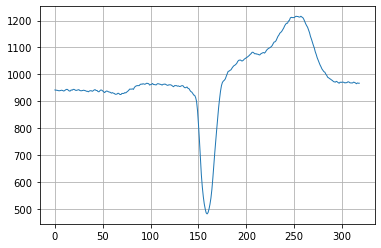

In [109]:
patientID = 0 
#classes = ['N', 'L', 'R', 'A', 'V', '/']
plt.plot(X[patientID,:])
print(classes[y[patientID]])
print(y[patientID])

In [103]:
prin)

[0 0 0 ... 4 4 4]
